# Phase 1: Attracting high potential sellers

##### Table of content:
1. [Descriptive analysis](#part1)
2. [Predictive analysis - which sellers should be prioritized?](#part2)
3. [Conclusion](#part3)

## <font color='blue'>Introduction</font>

This notebook consist of two parts; 1) a descriptive analysis and 2) a predictive analysis. The descriptive analysis aim to investigate how sellers land on the platform and what channels are more effective, while the predictive analysis aim the estimate which sellers the SDR/SR should prioritize in order to land on the platform. It is crucial for business to attract customers, in Olist's case sellers, which attract customers. Since Olist retain 15% of the order value, then if Olist wants to increase their revenue, they have to attract sellers which generate many orders and/or high valued orders.

## <font color='blue'>KPI's</font>
For the descriptive analysis and the predictive analysis, the investigations are based on two KPI's, 1) the conversion rate and 2) the sellers weekly revenue on average respectively. The conversion rate is defined by the percentage of closed qualified marketing leads out of the total number of qualified marketing leads.
        
$$\text{Conversion rate} = \frac{\text{Closed qualified marketing leads}}{\text{Total qualified marketing leads}}$$
        
The weekly revenue on average is defined by the total revenue divided by the number of weeks a given seller has been active on the platform. Where the number of weeks active on the platform is defined as the period between the date the seller was launched to the platform until the last registered date of a shipped order.
        
$$\text{Average weekly revenue} = \frac{\text{Total revenue}}{\text{Weeks active on the platform}}$$

## <font color='blue'>Setup 1</font>: Load Libraries

In [339]:
#Loading all libraries used in phase 1
import numpy as np
import pandas as pd
import sys, os
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()
sns.color_palette("Paired")
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.style.use('ggplot')

## <font color='blue'>Setup 2</font>: Load data
The notebook will focus on the marketing funnel dataset. Therefore, only the following datasets are investigated:

- olist_marketing_qualified_leads_dataset
- olist_closed_deals_dataset

First, the olist_closed_deals_dataset is investigated solely and later the two datasets are joined by the left-join operation and dataformat is set. 

In [340]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [341]:
# Reading the olist_marketing_qualified_leads_dataset
leads = load_table('olist_marketing_qualified_leads_dataset.csv')
#Reading the olist_closed_deals_dataset
closed_leads = load_table('olist_closed_deals_dataset.csv')

## <font color='blue'>Setup 2.1</font>:  Missing values

Missing values can cause errors in algorithms and real world data often has missing values.

First of all, there is no "good-way" to handle missing values. But in general there is three methods to handle missing values.

1. Remove rows or columns containing missing values
    - This is the simplest method for handling missing values. 
        - Pro's: easy too handle and doesn't add noise to data. 
        - Con's: can be too limiting for some datasets, i.e. removing too much information.
        
2. Impute missing values
    - Refers to the act of replacing the missing values with the mean, median, mode, a constant etc.
        - Pro's: we keep information, though adding some noise.
        - Con's: maybe missing values have a meaning?
        
3. Predict missing values
    - Refers to the act of imputing missing values by using a prediction rule .
        - Pro's: we keep information and approximates the missing values to the "true" information.
        - Con's: maybe missing values have meaning and the approximated "true" information get too biased.


In order to choose a meaningful approach, we need to get an overview of the missing values.

In [342]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),2)
    
    print(num_missing)

In [343]:
show_nans= lambda df: df[df.isnull().any(axis=1)]

We start by looking for missing values in the olist_marketing_qualified_leads_dataset

In [344]:
count_missing_values(leads)

                    Number  Percentage
mql_id                   0        0.00
first_contact_date       0        0.00
landing_page_id          0        0.00
origin                  60        0.01


We see the only column containing missing values for the olist_marketing_qualified_leads_dataset is the column `origin` with a total of 60 missing values. Lets take a look at the rows containing missing values in order to decide which method to proceed with.

In [345]:
show_nans(closed_leads.head())

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


Observations seem normal. Since we are not interested in dropping neither the columns or 60 observations, we choose to replace missing values with the category for *unknown* observations.

In [346]:
leads['origin'] = leads['origin'].fillna('unknown')

Now we look for missing values in the olist_marketing_qualified_leads_dataset.

In [347]:
count_missing_values(closed_leads)

                               Number  Percentage
mql_id                              0        0.00
seller_id                           0        0.00
sdr_id                              0        0.00
sr_id                               0        0.00
won_date                            0        0.00
business_segment                    1        0.00
lead_type                           6        0.01
lead_behaviour_profile            177        0.21
has_company                       779        0.93
has_gtin                          778        0.92
average_stock                     776        0.92
business_type                      10        0.01
declared_product_catalog_size     773        0.92
declared_monthly_revenue            0        0.00


If the column contains over 85% missing values then we choose to drop the column. Meaning we are dropping the columns `has_company`, `has_gtin`, `average_stock` and `declared_product_catalog_size`.

In [348]:
closed_leads = closed_leads.drop(['has_company'], axis=1)
closed_leads = closed_leads.drop(['has_gtin'], axis=1)
closed_leads = closed_leads.drop(['average_stock'], axis=1)
closed_leads = closed_leads.drop(['declared_product_catalog_size'], axis=1)

In [349]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0        0.00
seller_id                      0        0.00
sdr_id                         0        0.00
sr_id                          0        0.00
won_date                       0        0.00
business_segment               1        0.00
lead_type                      6        0.01
lead_behaviour_profile       177        0.21
business_type                 10        0.01
declared_monthly_revenue       0        0.00


Regarding the coloumns `lead_behaviour_profile`, `business_segment`, `lead_type` and `business_type` we have a total of 248 missing values. Since we are not interested in dropping neither the columns or ~30% of our observations, we choose to replace missing values with the their respectively category for *unknown* observations. I.e. we interpret the missing values of being either an *unknown* or *other* observation.

In [350]:
closed_leads['lead_behaviour_profile'] = closed_leads['lead_behaviour_profile'].fillna('unknown')
closed_leads['business_segment'] = closed_leads['business_segment'].fillna('other')
closed_leads['lead_type'] = closed_leads['lead_type'].fillna('other')
closed_leads['business_type'] = closed_leads['business_type'].fillna('other')

In [351]:
show_nans(closed_leads)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue


In [352]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0         0.0
seller_id                      0         0.0
sdr_id                         0         0.0
sr_id                          0         0.0
won_date                       0         0.0
business_segment               0         0.0
lead_type                      0         0.0
lead_behaviour_profile         0         0.0
business_type                  0         0.0
declared_monthly_revenue       0         0.0


We are now ready to investigate the two datasets.

## <font color='blue'>Setup 3</font>: Plotting functions
Some plotting function are defined to contribute the descriptive analysis with less coding and more describing text. All the following functions therefor only defined and called later in the script when needed. 

In [353]:
def land_page_map(df):
    """ Creates a dictionary to map the landing_page_id to a corresponding plot_id in 
    order to better visualize the label of each landing page. """
    
    land_page_dict = {}
    ID = 0
    for page in df['landing_page_id'].unique():
        land_page_dict[page] = ID
        ID += 1
        
    return land_page_dict

page_id_map = land_page_map(leads)

In [354]:
def create_mapping_column(df):
    """ Use the land_page_map function to add a column to a given DataFrame based on the
    landing_page_id. """
    
    plot_id = []
    for i in df['landing_page_id']:
        plot_id.append(page_id_map.get(i))
    
    return plot_id

In [355]:
def plot_timeline(df, title, pct = False, origin = False):
    """ Plots a timline of the number of market qualified leads id by each month. The 
    default setting plots the total number. If pct = True the total number is expressed 
    as a fraction of 100. If origin = True the calculation is made for each media type. """
    
    sns.color_palette("Paired")
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['first_contact_date'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_month'] = new[0]+'-'+new[1]+'-'+'01'
    
    series = series.groupby(['first_contact_month','origin'])['freq'].agg('sum').reset_index()
    
    series['percentage'] = series['freq']/len(df)
    series['first_contact_month'] = pd.to_datetime(series.first_contact_month)
    
    if origin == True:
        
        if pct == True:
            plt.figure(figsize=(20,6))
            sns.lineplot(data=series,x='first_contact_month',y='percentage',hue='origin',err_style=None)
            plt.title('Frequency over time by type of media where the lead was aquired')
            plt.ylabel('Frequency (%)', fontsize=12)
            plt.xlabel('Date', fontsize=12)
            plt.show()
        
        else:
            plt.figure(figsize=(20,6))
            sns.lineplot(data=series,x='first_contact_month',y='freq',hue='origin',err_style=None)
            plt.title('Frequency over time by type of media where the lead was aquired')
            plt.ylabel('Frequency', fontsize=12)
            plt.xlabel('Date', fontsize=12)
            plt.show()
    
    else:
        plt.figure(figsize=(20,6))
        sns.lineplot(data=series,x='first_contact_month',y='freq',err_style=None)
        plt.title(title)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.show()     
        

In [356]:
def plot_origin(df, year=True):
    """ Plots a barchart of the total number of market qualified leads id expressed as a 
    fraction of 100 by each type of meadia. The default setting plots a bar for every year
    in the data. If year = False there will only be one bar for each type of media. """
    
    sns.color_palette("Paired")
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_year'] = new[0]
    
    series = series.groupby(['first_contact_year','origin'])['freq'].agg('sum').reset_index()
    series['percentage'] = round(series['freq']/len(df),4)
    
    if year==True:
        plt.figure(figsize=(20,6))
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8, hue='first_contact_year')
        plt.title('Frequency by year of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()
    else:
        plt.figure(figsize=(20,6))
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8)
        plt.title('Frequency of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()

In [357]:
def plot_top_n_land_page(df, n, conv_rate = False):
    """ Plots a barchart of the top n landing pages based on the total number of market 
    qualified leads id expressed as a fraction of 100."""
    
    sns.color_palette("Paired")
    
    series = pd.DataFrame(df,columns = ['landing_page_id'])
    series['plot_id'] = create_mapping_column(df)
    
    series['freq'] = series['plot_id'].map(series['plot_id'].value_counts())
    series = series.groupby(['landing_page_id','plot_id'])['freq'].agg('max').reset_index()
    series = series.sort_values(by=['freq'],ascending=False)
    series['percentage'] = round(series['freq']/len(df),2)
    series['conversion_rate (%)'] = round(series['freq']/8000,4)
    page_count = series[:n]
    
    plt.figure(figsize=(20,6))
    sns.barplot(data=page_count, x='plot_id', y='percentage', order=page_count['plot_id'], alpha=0.8)
    plt.title('Top 10 frequency of landing page id where the lead was aquired')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Landing page id', fontsize=12)
    plt.show()
    
    if conv_rate == True:
        print(page_count[['landing_page_id', 'plot_id', 'freq','conversion_rate (%)']])
    else:
        print(page_count[['landing_page_id', 'plot_id', 'freq','percentage']])

In [358]:
def plot_closed_vs_not(df1, df2):
    """ Plots the conversion rate of each media type. The left-sided bar is the conversion rate,
    while the righ-sided bar is the number of total number of market qualified leadsid expressed 
    as a fraction of 100."""
    
    sns.color_palette("Paired")
    
    series = pd.DataFrame(df1,columns = ['mql_id','origin'])
    ids = [x for x in df2.mql_id]
    series['Result of lead'] = ['Closed' if x in ids else 'Not closed' for x in series.mql_id]
    series['freq'] = series.groupby(['origin','Result of lead'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    series = series.groupby(['origin','Result of lead'])['freq'].agg('max').reset_index()
    series['percentage'] = np.where(series['Result of lead']=='Not closed', round(series['freq']/len(df1),4), round(series['freq']/len(df2),4))
    series['conversion_rate'] = np.where(series['Result of lead']=='Not closed', round(series['freq']/len(df1),4), round(series['freq']/len(df1),4))
    
    plt.figure(figsize=(20,6))
    sns.barplot(data=series, x='origin',y='percentage', hue='Result of lead', alpha=0.8)
    plt.title('The conversion rate for each type of media')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Origin', fontsize=12)
    
    plt.show() 
    
    for index, row in series.iterrows():
        if row['Result of lead'] == 'Closed':
            print("Type of mediad: %-30s Conversion rate: %4.1f" % (row.origin, np.round(row.conversion_rate*100,4)))

## <font color='blue'>Part 1</font>: Descriptive analysis
<a id=part1></a>

In terms of providing some context, the following discription is taken from the documentation:
> A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:
1. After a lead fills in a form at a landing page, a filter is made to select the ones that are qualified to sell their products at Olist. They are the Marketing Qualified Leads (MQLs).
2. Then the Marketing Qualified Leads (MQLs) is contacted by a Sales Development Representative. (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist. His products are published on marketplaces and ready to sell!

To investigate how sellers land on the platform and what channels are more effective we want to answer the following questions:

1. How does the number of marketing qualified leads move over time?
2. Which landing pages brings in most qualified leads?
3. Which of the landing pages is most effective? 
4. Which of the media types is most effective? 
5. How long time is the average closing? 
6. Which SDR/SR is best at talking to different business segments?

### <font color='blue'>1.1</font>:  How does the number of marketing qualified leads move over time?

At first, we are exploring the leads dataset to get an idea about how many leads we have. 

In [359]:
leads.describe()

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,8000
unique,8000,336,495,10
top,788e8dcccb8757a5a7f29481ec1d6fc0,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


In the olist marketing qualified leads dataset we find 8.000 unique marketing qualified leads. Those 8.000 leads was acquired on 495 unique landing pages spread out on 336 unique contact dates. The landing pages can be categorised into 10 types of media where the lead was acquired. The first lead was acquired 06-14-2017 and the latest 05-31-2018.

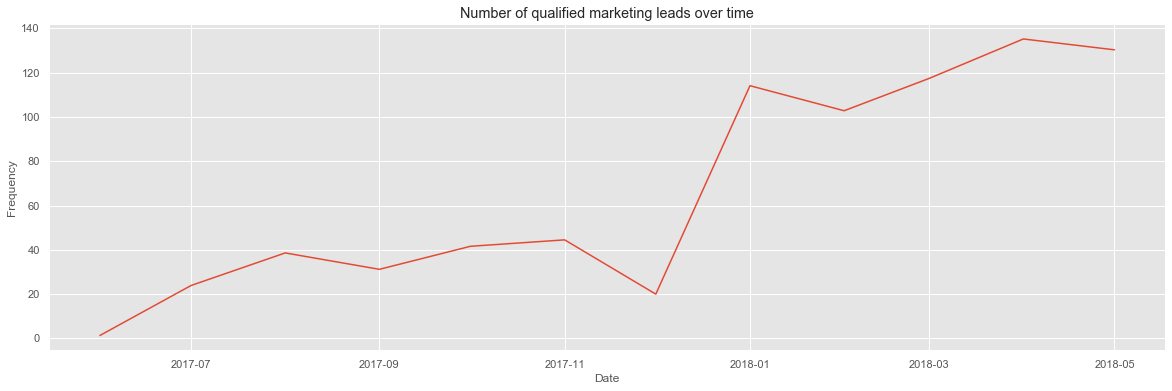

In [360]:
#Plotting the leads as a function of time using one of the plotting functions defined in setup 3
plot_timeline(leads, "Number of qualified marketing leads over time", pct = False, origin = False)

Between November 2017 and January 2018 we see a significant rise in acquired marketing qualified leads. This overview can be split into different types of media where the lead originated. 

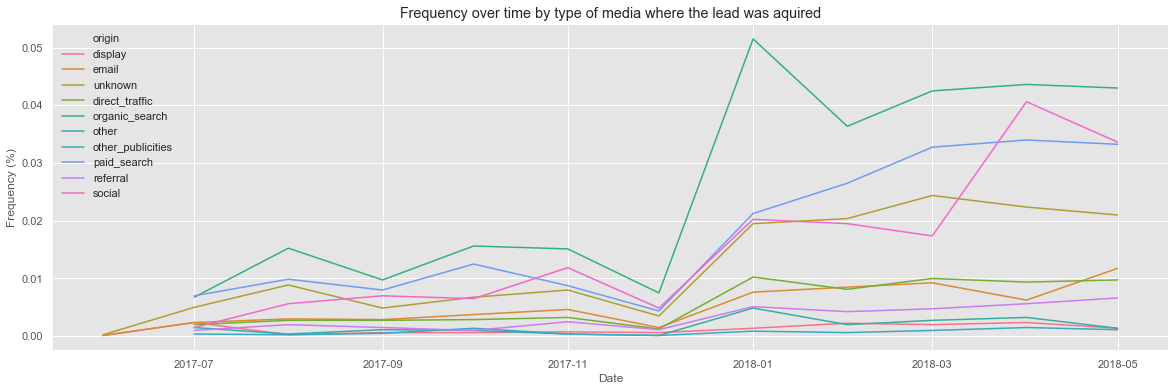

In [361]:
#Plotting the different lead types as a function of time using one of the plotting functions defined in setup 3
plot_timeline(leads, "", pct = True, origin = True)

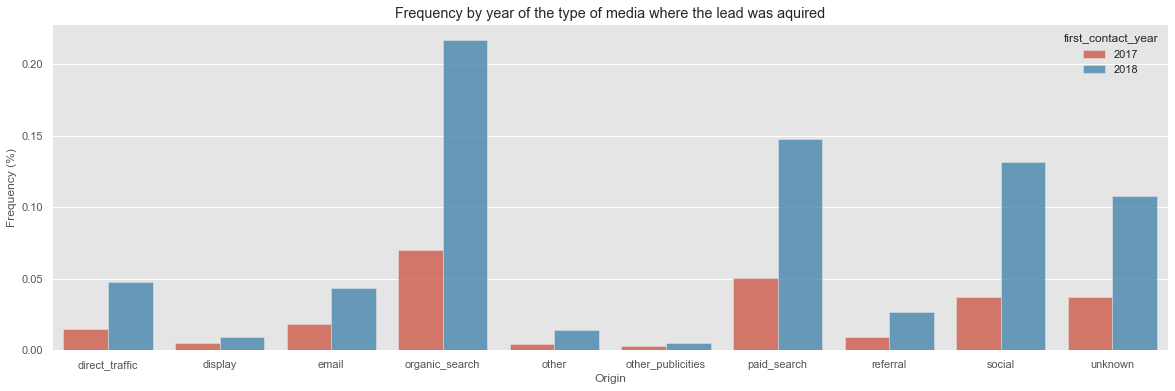

In [362]:
#Plotting the frequency by year
plot_origin(leads, year=True)

In general, we see an increase in the number of qualified lead over time. However, as the last plot in 1.1 shows, the relative increase in `organic_search`, `paid_search` and `social` has been most significant. 

### <font color='blue'>1.2</font>:  Which landing pages brings in most qualified leads?

In the below cell, we are providing an overview over which landing pages that results in the most qualified leads. Note that the different landing pages does not have an interpretable name, and thus we have turned the landing page ID's into integers. 

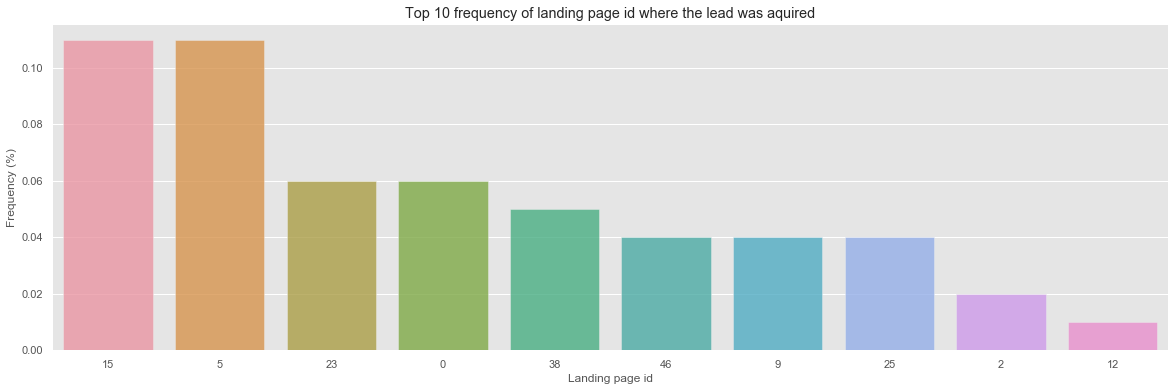

                      landing_page_id  plot_id  freq  percentage
356  b76ef37428e6799c421989521c0e5077       15   912        0.11
61   22c29808c4f815213303f8933030604c        5   883        0.11
159  58326e62183c14b0c03085c33b9fdc44       23   495        0.06
262  88740e65d5d6b056e0cda098e1ea6313        0   445        0.06
394  ce1a65abd0973638f1c887a6efcfa82d       38   394        0.05
122  40dec9f3d5259a3d2dbcdab2114fae47       46   330        0.04
468  f017be4dbf86243af5c1ebed0cff36a2        9   310        0.04
443  e492ee5eaf1697716985cc6f33f9cd9b       25   291        0.04
321  a7982125ff7aa3b2054c6e44f9d28522        2   156        0.02
228  73f31a40697cc90a86c1273563ac230e       12   115        0.01


In [363]:
#Plotting top 10 landing pages
plot_top_n_land_page(leads,10, conv_rate = False)

Over 20% of the marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c*. This insight enables Olist to investigate whether this is due to heavier marketing budgets or whether it is because of the landing pages being exploited more relevant places. Such investigation would depend on more specific data, which is not obtained in this project. 

### <font color='blue'>1.3</font>: Which of the landing pages is most effective? 
The olist_marketing_qualified_leads_dataset is now joined with the olist_closed_deals_dataset. The two datasets are merged, so we can obtain insights on the amount of closed deals and compare it with the total qualified marketing leads. This enables us to find which landing page is the most effective one, i.e. closing as many leads as possible.

In [272]:
#Merging the closed leads and leads dataset and displaying information about the closed leads dataset
closed_leads = closed_leads.merge(leads, on="mql_id", how= "left")
closed_leads.describe(include=['O'])

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,first_contact_date,landing_page_id,origin
count,842,842,842,842,842,842,842,842,842,842,842,842
unique,842,842,32,22,824,33,8,10,3,195,134,10
top,a2de60ae969948c62475144651c21281,698f5fa55a5f73d0740e9d9a773e8093,4b339f9567d060bcea4f5136b9f5949e,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-04 03:00:00,home_decor,online_medium,cat,reseller,2018-02-06,22c29808c4f815213303f8933030604c,organic_search
freq,1,1,140,133,6,105,332,407,587,14,174,271


In the joined dataset we find 842 unique closed leads. I.e. out of the 8.000 marketing qualified leads only ~10% was closed. The 842 closed leads was contacted by one of 32 sales development representatives (SDR), while the consultancy was provided by 22 different sales representatives (SR). The `sellers` are categorised into 33 different `business_segment`, 3 `business_type`, 8 `lead_type` and 9 `lead_behaviour_profile`. Furthermore, an `average_stock`, `declared_product_catalog_size` and `declared_monthly_revenue` is occasionally noted. The first lead was closed 12-05-2017 and the latest 11-14-2018.

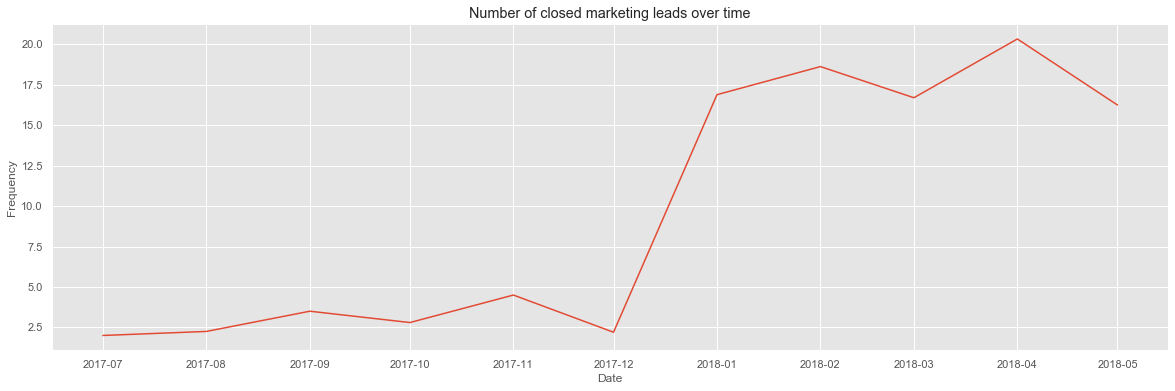

In [273]:
#Plotting the amount of closed marketing leads as a function of time. 
plot_timeline(closed_leads, "Number of closed marketing leads over time", pct = False, origin = False)

Between November 2017 and January 2018 we see a significant rise in acquired marketing qualified leads. This also corresponds to the fact that Olist had a significant increase in qualified leads in the same period. This indicates a correlation between the number of qualified leads and closed leads. 

To investigate which of the landing pages is most effective, i.e. closes the highest percentage of all qualified leads, the following plot shows which landing pages are most effective in terms of generating closed leads. 

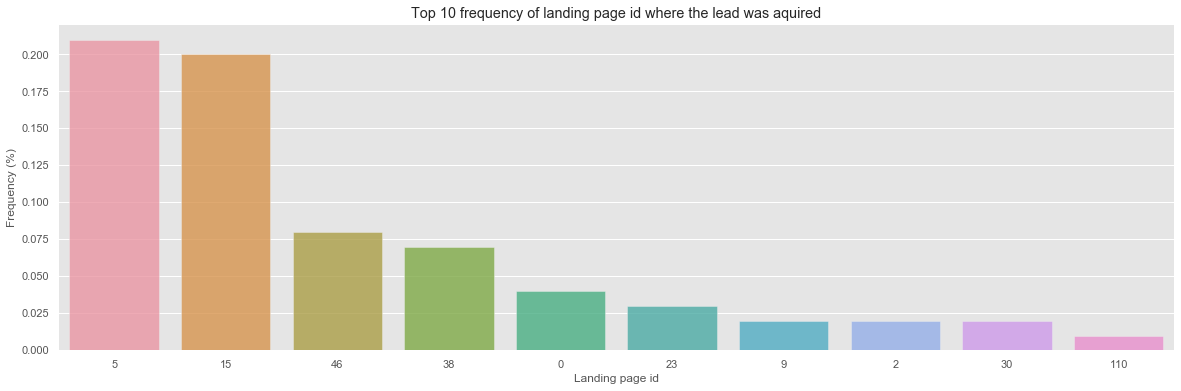

                      landing_page_id  plot_id  freq  conversion_rate (%)
23   22c29808c4f815213303f8933030604c        5   174               0.0217
95   b76ef37428e6799c421989521c0e5077       15   171               0.0214
44   40dec9f3d5259a3d2dbcdab2114fae47       46    67               0.0084
106  ce1a65abd0973638f1c887a6efcfa82d       38    59               0.0074
77   88740e65d5d6b056e0cda098e1ea6313        0    31               0.0039
50   58326e62183c14b0c03085c33b9fdc44       23    27               0.0034
126  f017be4dbf86243af5c1ebed0cff36a2        9    21               0.0026
86   a7982125ff7aa3b2054c6e44f9d28522        2    18               0.0022
24   241f79c7a8fe0270f4fb79fcbbcd17ad       30    14               0.0018
68   7fa6214d82e911d070f51ef79381b956      110    11               0.0014


In [274]:
#Plotting top 10 landing pages for closed leads
plot_top_n_land_page(closed_leads,10, conv_rate = True)

The two landing pages converting the most qualified leads into closed leads are the same top to pages generating the most qualified leads, which might sound trivial. However, relatively to how many qualified leads they are generating, both landing page _22c29808c4f815213303f8933030604c_ and _b76ef37428e6799c421989521c0e5077_ are generating singificantly more closed leads than any other landing page and thus have a higher conversion rate. 

In fact over 40% of the closed marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c* and both converts ~2% of the qualified leads to closed leads.

### <font color='blue'>1.4</font>: Which of the media types is most effective? 

Different landing pages are categorized into different media types, which might also make a difference in terms of conversion ratio. The effect of where the different leads originated is assed in the following cells. 

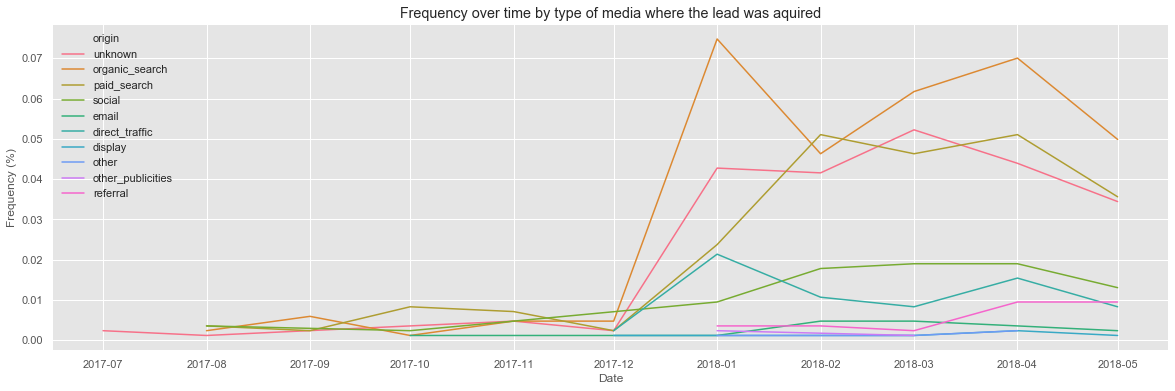

In [275]:
#Plotting frequency of closed leads by the different media types
plot_timeline(closed_leads, "", pct = True, origin = True)

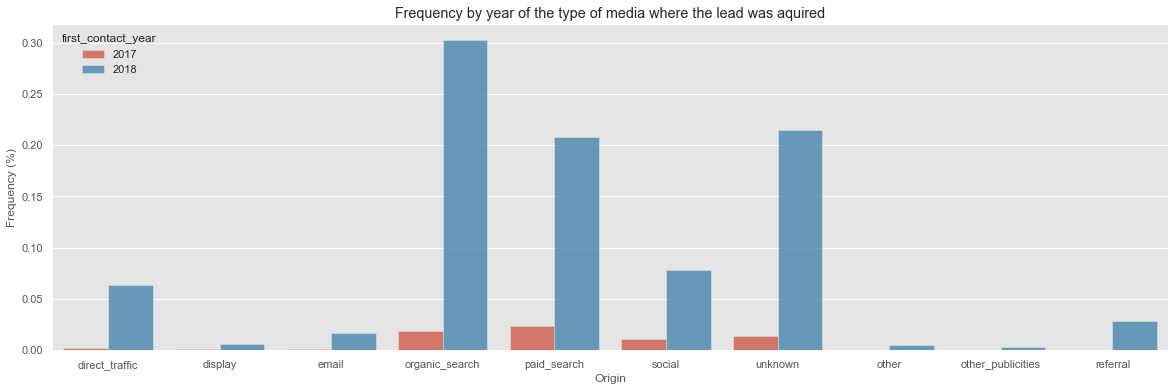

In [276]:
#Plotting the different media types in terms of a per-year frequency 
plot_origin(closed_leads, year=True)

This increase is again primarily attributable to the use of the media types `organic_search`, `paid_search` and `social`, as was the case in the qualified leads. 

The different media types' conversion rate can be assessed relative to how many qualified leads they are generating. The following visualization provides an overviw of how many "closed" or "not closed" leads each media type generates as percentage measure. Here "not closed" leads are defined by aquired qualified lead that are not converted into closed leads.

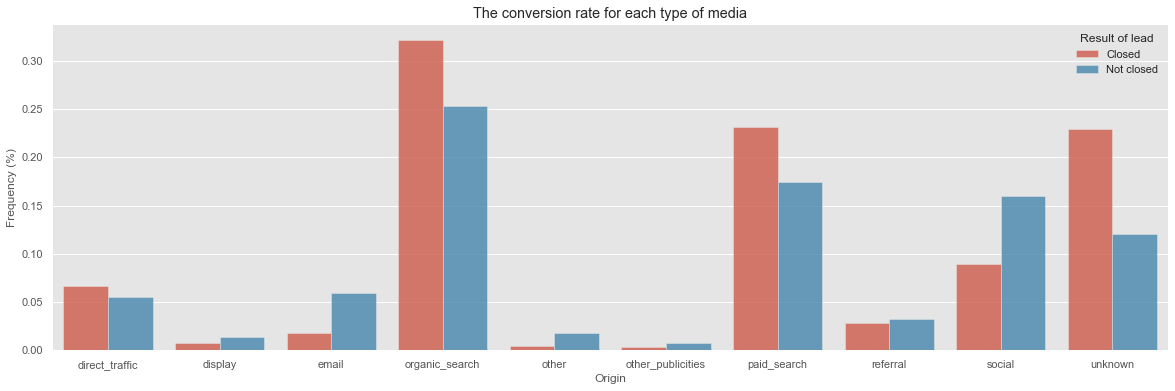

Type of mediad: direct_traffic                 Conversion rate:  0.7
Type of mediad: display                        Conversion rate:  0.1
Type of mediad: email                          Conversion rate:  0.2
Type of mediad: organic_search                 Conversion rate:  3.4
Type of mediad: other                          Conversion rate:  0.1
Type of mediad: other_publicities              Conversion rate:  0.0
Type of mediad: paid_search                    Conversion rate:  2.4
Type of mediad: referral                       Conversion rate:  0.3
Type of mediad: social                         Conversion rate:  0.9
Type of mediad: unknown                        Conversion rate:  2.4


In [277]:
#Plotting closed vs not closed
plot_closed_vs_not(leads, closed_leads)

The two media types converting the most qualified leads into closed leads are the same generating the most qualified leads, which might sound trivial. However, the media type `social` doesn't convert many of the qualified leads as it generates. Instead, the `unknown` media type converts the same amount of qualified leads as the `organic_search`. Relatively to how many qualified leads it's generating, it can be viewed as more effective. Thus, it will make great sense to expand the level of detail for this category, since the category contain effective media types that are impossible to draw conclusion upon.

To sum up, the media types `organic_search`, `paid_search` and `unknow` stands for ~75% of the closed qualified leads, and converts 3,4%, 2,4% and 2,4% respectively.   

Now we want to look into the persons being responsible of the conversion. The Sales Development Representatives and the Sales Representatives to be precise. 

### <font color='blue'>1.5</font>:  How long is the average period for closing a seller?

The averegage period for closing a seller is measured by finding the number of days between the seller was approved being a qualified lead and the date the deal was signed. To find the number of days between the two dates we need to ensure the columns are in the right format.

In [278]:
#Changing these columns to datetimes
closed_leads.first_contact_date = pd.to_datetime(closed_leads.first_contact_date)
closed_leads.won_date = pd.to_datetime(closed_leads.won_date)

Then we can subtract the date the deal was signed from the date of the first contact.

In [279]:
#Making an overview of the period from initial contact to closed deal
closed_leads["closing_period"] = closed_leads.won_date-closed_leads.first_contact_date

Since a closing period can't be negative, we check if the feature extraction is done correctly.

In [280]:
closed_leads[closed_leads.closing_period.values/np.timedelta64(1, 'D')<0]

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period
667,b91cf8812365f50ff4bda4bcd6206b05,5e063e85d44b0f5c3e6ec3131103a57e,a8387c01a09e99ce014107505b92388c,495d4e95a8cf8bbf8b432b612a2aa328,2018-03-06 19:38:55,health_beauty,online_big,cat,reseller,0.0,2018-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search,-2 days +19:38:55


The feature extraction seems to been done correctly. However, one observation contains an impossible `won_date`. Therefor we choose to remove this observation from our dataset, since it must be due to a human error.

In [281]:
closed_leads = closed_leads.drop(667)

Since we have now obtained the time difference from when the initial contact was made until the closing, we are now able to use this datastrucutre to plot the distribution. 

In [282]:
#Example od a datastructure:
print("This is how the data is formatted: ",closed_leads.closing_period[0])
print("This is the period plotted: ", closed_leads.closing_period.values[0]/np.timedelta64(1, 'D'))

This is how the data is formatted:  5 days 19:58:54
This is the period plotted:  5.832569444444444


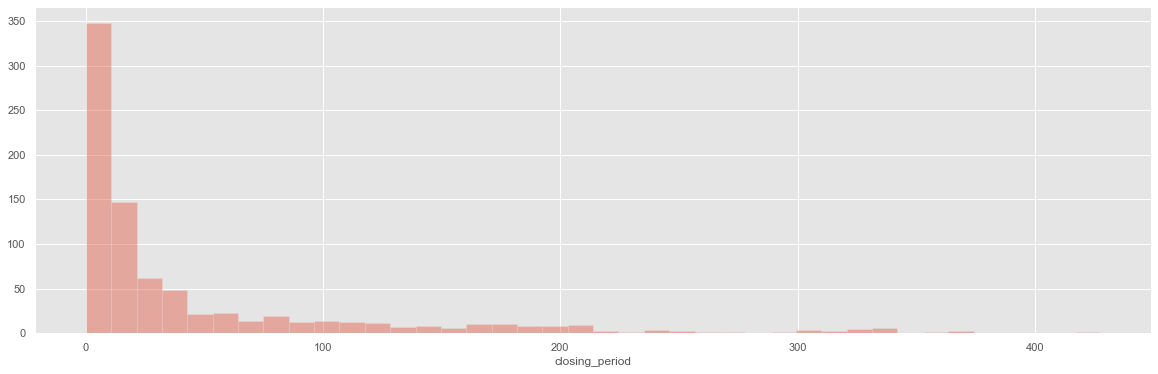

In [283]:
plt.figure(figsize=(20,6))
sns.distplot(closed_leads.closing_period/np.timedelta64(1, 'D'),bins=40, kde = False);

The plottet distribution of the period for closing a seller is formed like a long tail, i.e. the longer the closing period gets the less frequent the occurence is. The long tail shape of the distribution tell us there might be difference between the median and the average periode for closing a seller.

In [284]:
closed_leads.closing_period.describe()

count                        841
mean     49 days 03:51:12.171224
std      75 days 08:38:01.457963
min              0 days 02:00:00
25%              5 days 20:38:20
50%             14 days 17:19:55
75%             55 days 03:00:00
max            427 days 13:14:37
Name: closing_period, dtype: object

As expected we see that the average periode for closing a seller is 49 days, while the median is only 14 days. This tells us it might be a good idea to investigate the outliers more closely to see if they have any Sales Representative or Sales Development Representative in common.

A Sales Development Representative is the one having the initial contact witht the company, right after the company has signed up on the landing page. The SDR is noting some general information and arranging a meeting for when the business can meet a Sales Representative who may win or lose the deal.

In [285]:
sdr = closed_leads[['mql_id','sdr_id','sr_id','closing_period']]
sdr['closing_period']=sdr.closing_period/np.timedelta64(1, 'D')
sdr = sdr[sdr['closing_period']>=200]
sdr.describe(include='O')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mql_id,sdr_id,sr_id
count,52,52,52
unique,52,23,17
top,67577e94367b2efc073a5c9085a0e31d,f42a2bd194f7802ab052a815c8de65b7,068066e24f0c643eb1d089c7dd20cd73
freq,1,7,8


Now we only look at the closed qualified leads which was closed after a period of more than 200 days. Here we have 52 closed qualified leads, which were closed by 23 unique SDR's and 17 unique SR's

In [286]:
sdr.sdr_id.value_counts()[:5]

f42a2bd194f7802ab052a815c8de65b7    7
b90f87164b5f8c2cfa5c8572834dbe3f    5
e7dff61b78bebffa71678e126ce669ad    5
45749fb708130f78d0db07d8d80f030b    4
34d40cdaf94010a1d05b0d6212f9e909    3
Name: sdr_id, dtype: int64

Here we see that the some Sale Development Representatives are having a hard time closing qualified leads fast.

In [287]:
sdr.sr_id.value_counts()[:5]

068066e24f0c643eb1d089c7dd20cd73    8
d3d1e91a157ea7f90548eef82f1955e3    5
9749123c950bf8363ace42cb1c2d0815    5
de63de0d10a6012430098db33c679b0b    4
495d4e95a8cf8bbf8b432b612a2aa328    4
Name: sr_id, dtype: int64

The same goes on for some Sale Representatives. This might be due to reliable causes, but it would be a good idea to investigate those SDR's and SR's in terms of gaining insight into why some qualified leads are closed after 200 days.

### <font color='blue'>1.6</font>:  Which SDR/SR is best at talking to different business segments?

In general, it is quite difficult to say whether a SR or a SDR is effective, relative to how many deals they did not close. Since the SR's and SDR's are not present in the olist_marketing_qualified_leads_dataset, it is not possible to measure their conversion ratio. 
Therefore, we assume they have a steady stream of contact with potential sellers, and that some SR's and SDR's are just better at closing the sellers than other SR's and SDR's. 

The following distributions of the rate of closed customers can then be used to address how potentially high value sellers should be contacted and **by who**. 

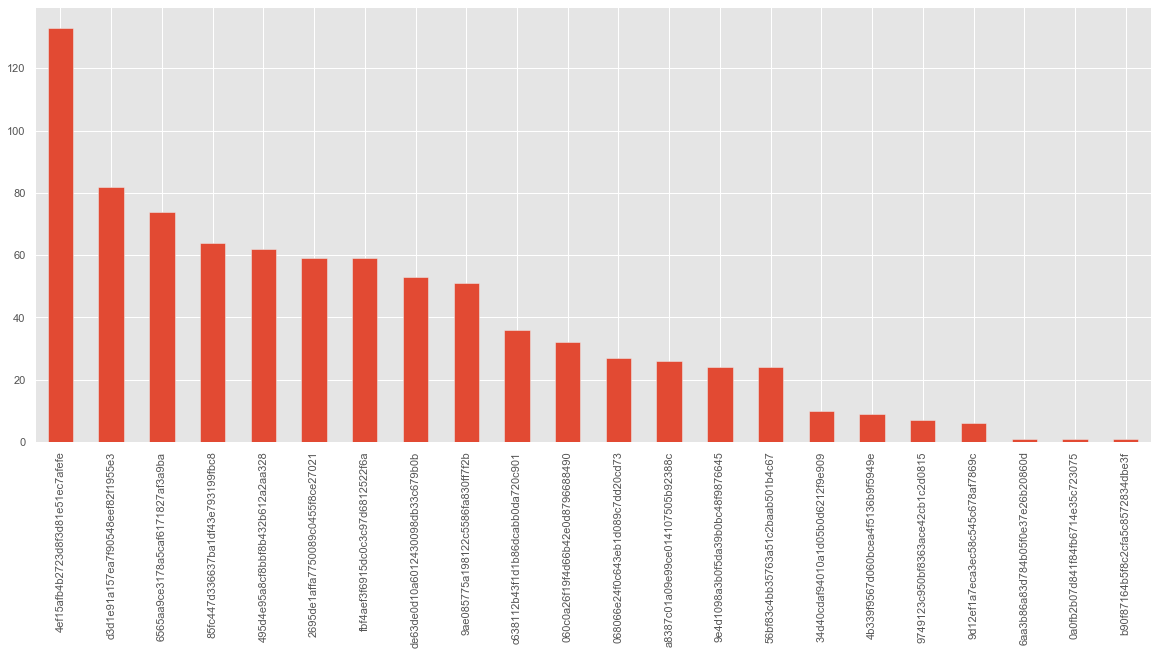

In [288]:
closed_leads.sr_id.value_counts().plot.bar();

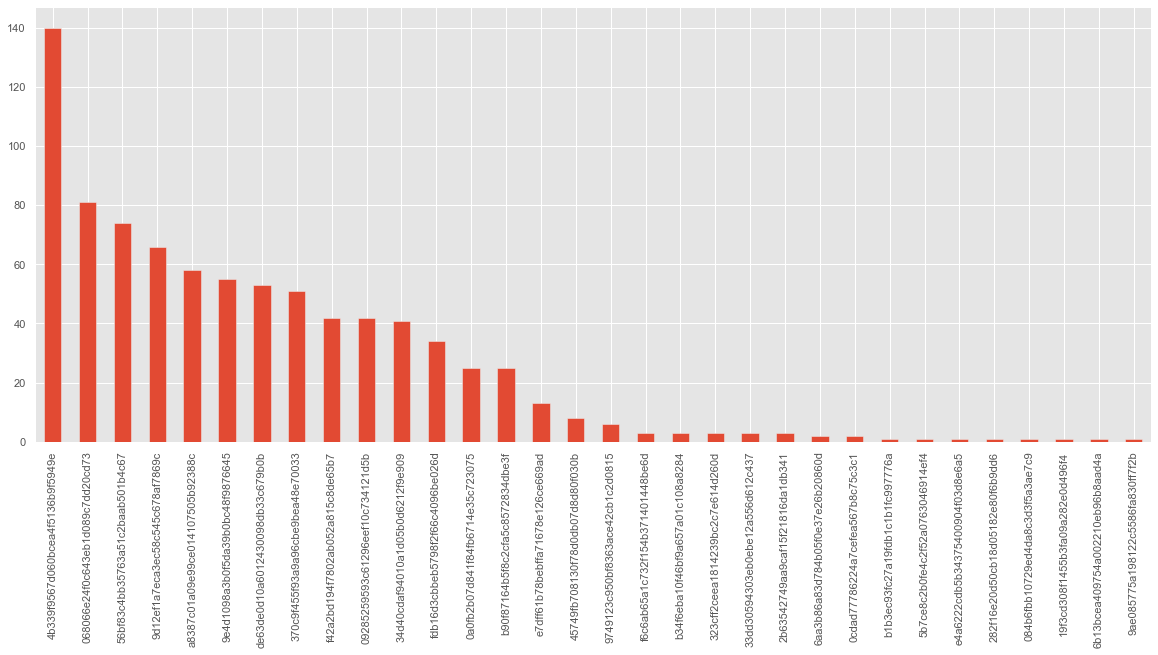

In [289]:
closed_leads.sdr_id.value_counts().plot.bar();

We can also look into whether any SR's or SDR's gets specialized in specific `business_segment` or `lead_type`. 

In [290]:
#Creating a dataframe holding the different business segments
df_seg = closed_leads.groupby(["sr_id","business_segment"]).count().seller_id.reset_index(name="count")

#Ordering the data properly and removing nan values
df_seg = df_seg.pivot(index= "sr_id", columns= "business_segment", values= "count")
df_seg = df_seg.fillna(0)

#Creating a total column to order the data for later plotting. After ordering, the total column is dropped
df_seg["total"] = df_seg.sum(axis=1)
df_seg = df_seg.sort_values("total",ascending= True)
df_seg = df_seg.drop(["total"],axis=1)

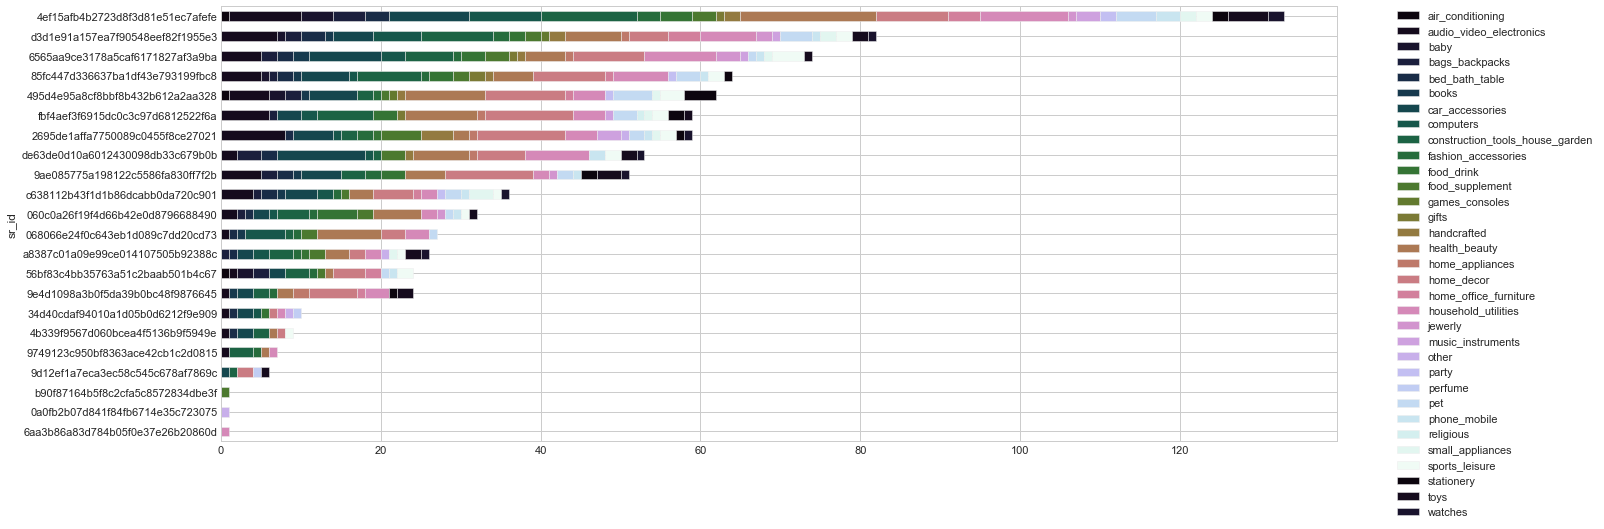

In [291]:
plt.style.use(['seaborn-whitegrid'])
sns.set_palette("cubehelix",30)
df_seg.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

From the above plot it is clear that no Sale Representatives gets assigned to a specific `business_segment`. However, it would make sense to specialize Sale Representatives in a specific `business_segment`, since it require one pitch to convince perfume company to enter the platform and another pitch to convice a book company.

Lets see if the goes for `lead_type`.

In [292]:
#Same procedure with lead type:
df_lead = closed_leads.groupby(["sr_id","lead_type"]).count().seller_id.reset_index(name="count")

df_lead = df_lead.pivot(index= "sr_id", columns= "lead_type", values= "count")
df_lead = df_lead.fillna(0)

df_lead["total"] = df_lead.sum(axis=1)
df_lead = df_lead.sort_values("total",ascending= True)
df_lead = df_lead.drop(["total"],axis=1)

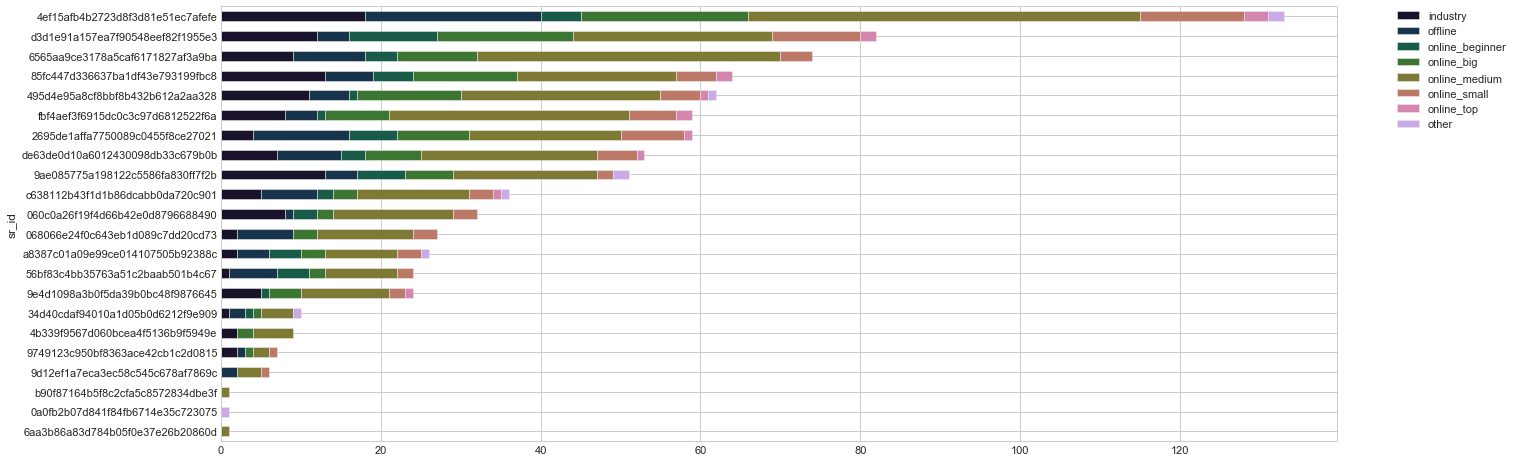

In [293]:
plt.style.use(['seaborn-whitegrid'])
sns.set_palette("cubehelix",10)
df_lead.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

The plot proves the same point, that the different SR's does not get specific `lead_type`, which could potentially be easier to close. However, they are all recieving a variety of different `business_segment` and `lead_type`, which indicate that some SR's are just inherintly better at closing the sellers. 

### <font color='blue'>1.7</font>:  Conclusion on the descriptive analysis

The descriptive analysis tells us:
- From 2017 to 2018 we have a significant rise in leads and also a significant rise in closed leads. Though, the significant rise is not due to a more effective process, rather because of more leads fills in the forms on the landing pages.
- The increase is delivered by the media types `organic_search`, `paid_search`, `social` and `unknown`. However, `organic_search`, `paid_search` and `unknown` has proven to be more effective by a convertion ratio on 3.4%, 2.4% and 2.4% respectively. In total they stand for 2/3 of the closed leads. 
- The different media types guide the lead into a landing page. Here specially two landing pages stand out. `landing_page_id` *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c* ~20% of the qualified marketing leads and ~40% of the closed leads. Thus, they have proven to be the most effective landing pages with a conversion ratio on ~2% each.
- Some Sales Development Representatives and Sales Representatives have a extreme long closing period. 
- Furthermore, neither Sales Development Representatives or Sales Representatives are specialized in marketing qualified leads coming from a specific `business_segments` or `lead_type`. 

## <font color='blue'>Part 2</font>: Predictive analysis - which sellers should be prioritized?
<a id=part2></a>

First of all, machine learning is the ability to use past experience to take better actions in new situations.

We want to use machine learning
1. When we have a pattern 
    - In this case, we want to see if there is a pattern on which qualified marketing leads end up generating a high average weekly revenue.
2. When we can't pin the pattern mathematically
    - Meaning we can't say `business_segment`*`origin`+`declared_monthly_revenue` = _high average weekly revenue_
3. When we have data on it.
    - Lots of data! We need plenty of occurences of closed leads mapped to their average weekly revenue

The goal is to feed an algorithm with a training sample, _S = {(X1, Y1),...,(Xn,Yn)}_ to produce a prediction rule _h_ in order to predict average weekly revenue of a new sample _X_. By creating a stable prediction rule Based on the feature space the Sale Development Representatives gather from the qualified leads. Olist will be able to predict the average weekly revenue and thereby indicate an importance of closing a given lead. Furthermore, this prediction rule can be used to flag what leads the Sale Respresentaives should focus on, and prioritize which Sales Representative Olist should to matched to which leads.

Our task is more formally to build a prediction model to approximate average weekly revenue. 

### <font color='blue'>2.2</font>: Feature extraction

In order to extract the target variable *weekly average turnover*, we merge the olist_closed_deals_dataset with the olist_order_items_dataset. But first, we need to calculate the *weekly average turnover*. This is done in the olist_order_items_dataset before merging. To do the calculation we also need a variable telling how many days a seller has been active on the platform. We call this variable *time_as_seller*.

In [297]:
all_orders = load_table("olist_order_items_dataset.csv")
all_orders.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [298]:
print(np.round((1-(98666/112650))*100,2),'% of the orders includes more than 1 item')

12.41 % of the orders includes more than 1 item


Thus, we need to make an aggregation of the order price grouped by both the order id and seller id. In this way we ensure that the calculations can handle orders including multiple products and multiple sellers. We do the calculation seperately from the all_orders dataframe and instead call it total_revenue.

In [299]:
order_items = load_table("olist_order_items_dataset.csv")
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']
total_revenue = order_items_filt.groupby(['seller_id'])['order_price'].agg('sum').reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


Then we estimate the time a seller has been active on the platform and call variable *time_as_seller*. As we want to extract the *weekly average turnover*, a new variable is made by dividing the *time_as_seller* with 7. We call this variable *weeks_as_seller*.

In [300]:
all_orders['shipping_limit_date'] = pd.to_datetime(all_orders['shipping_limit_date'])
all_orders['time_as_seller'] = all_orders['shipping_limit_date'].max() - all_orders['shipping_limit_date']
all_orders['weeks_as_seller'] = all_orders['time_as_seller'].dt.days/7

Since *weeks_as_seller* is defined by the last registrated shipment, we need to find the max value of this variable.

In [301]:
all_orders = all_orders.groupby(['seller_id'])['weeks_as_seller'].agg('max').reset_index()

Then we merge the total_revenue dataframe and the all_orders dataframe and get a new dataframe called sellers. This dataframe has the seller id as primary key and includes their total revenue and the total days active on the platform. Thus, we can calculate the target variable *weekly average turnover*.

In [302]:
sellers = all_orders.merge(total_revenue, on="seller_id", how= "left")
sellers['weekly_avg_revenue']=sellers.order_price/sellers.weeks_as_seller
sellers.describe()

,weeks_as_seller,order_price,weekly_avg_revenue
count,3095.000000,3095.000000,3095.000000
mean,127.825987,4526.500514,31.873235
std,28.362946,14364.843840,93.683017
min,83.428571,3.500000,0.023048
25%,102.000000,219.410000,1.912564
50%,125.857143,847.350000,7.133456
75%,153.357143,3403.995000,25.111616
max,185.428571,232542.720000,1639.781651


We can now join our two extracted features with the olist_closed_deals_dataset. This in done on the seller id with a inner join.

In [328]:
data = closed_leads.merge(sellers, on='seller_id', how="inner")
data = data.drop(['weeks_as_seller','order_price','sdr_id','sr_id','won_date',
      'first_contact_date','landing_page_id','closing_period'],axis=1)

In [329]:
data.describe(include='O')

,mql_id,seller_id,business_segment,lead_type,lead_behaviour_profile,business_type,origin
count,379,379,379,379,379,379,379
unique,379,379,29,8,7,3,9
top,512182619d12ae0863827b7e5ab97f19,7816cd9c5b1238e320545f5bf7eb80e8,home_decor,online_medium,cat,reseller,organic_search
freq,1,1,44,172,183,286,112


The inner join resulted in a 55% data reduction. I.e. we were only able to calculate a weekly_avg_revenue for 45% of the sellers in the olist_closed_deals_dataset.

But we can now plot the weekly average revenue for the 379 closed qualified marketing leads by the media type they originated from. 

In [336]:
def plot_weekly_revenue(df):
    plot_data = df.groupby('origin')['weekly_avg_revenue'].agg('mean').reset_index()
    freq = df.groupby('origin')['mql_id'].agg('count').reset_index()
    plot_data['freq'] = freq.mql_id
    
    plt.bar(plot_data.origin, plot_data.freq, color='lightblue')
    plt.ylabel('Frequency')      

    axes2 = plt.twinx()
    axes2.plot(plot_data.origin, plot_data.weekly_avg_revenue, color='red', label='Avg. weekly revenue (BRL)')
    axes2.set_ylabel('Avg. weekly revenue')
    
    plt.axhline(plot_data['weekly_avg_revenue'].mean(), color='black', linestyle='dashed', linewidth=1, label='Avg.')
    
    #plt.title('Number of closed leads and their avg. weekly revenue by origin')
    plt.legend()

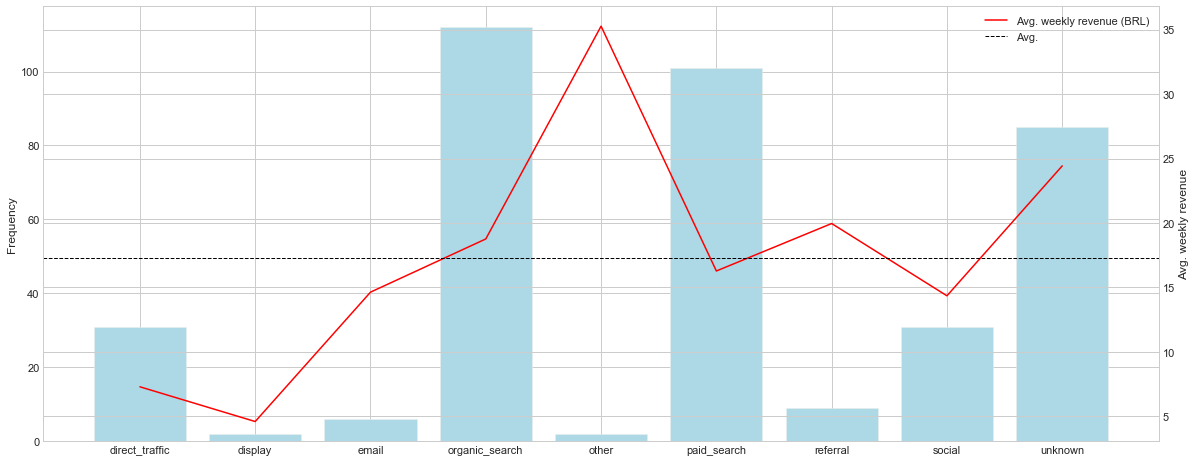

In [337]:
plot_weekly_revenue(data)

Interesting. Here we see that the sellers with the highest average weekly revenue originates from the most effective media types: `organic_searc`, `paid_searc` and `unknow`.

### <font color='blue'>2.3</font>: Prediction model
We will only feed the model with the information gathered by the Sales Development Representatives when they first contact a qualified marketing lead. Unfortunately, we aren’t quite ready to feed the raw data into a prediction model. First, we are required to convert any categorical variable to a numeric representation. There are basically two methods to do this: 

1. Label Encoder
    - A label encoder encodes labels with a value between 0 and n_classes-1 where n is the number of distinct labels. 
        - pros: Keep the dimensionality to a minimum.
        - cons: The model can misunderstand the data to be in a meaningful order, 0 < 1 < 2.

2. One-Hot Encoder
    - One-Hot encoder, takes a column which has categorical data and splits the column into multiple columns. The categorical data are replaced by 1's and 0's, depending on which observation has which category. 
        - pros: The model won't derive false correlations.
        - cons: The data becomes more sparse, the dimensionality increases and the computation therefor gets more expensive.

The categorial variables are converted into dummy/indicator variables using pandas get_dummies()-function. 
Furthermore, the correlation between the features and the target variables are shown in a list.

In [307]:
#convert categorical columns to numerical
df = pd.get_dummies(data, columns=['business_segment', 'lead_behaviour_profile', 
                                     'lead_type','business_type','origin'])

In [308]:
#calculate and show correlations
corr_matrix = df.corr()
corr_matrix['weekly_avg_revenue'].sort_values(ascending=False)

weekly_avg_revenue                                  1.000000
business_segment_watches                            0.474464
lead_type_other                                     0.167392
lead_type_online_big                                0.149175
business_segment_small_appliances                   0.097318
lead_behaviour_profile_shark                        0.092857
business_type_reseller                              0.084449
business_segment_home_appliances                    0.068019
origin_unknown                                      0.054146
lead_behaviour_profile_unknown                      0.051647
business_segment_home_office_furniture              0.021740
business_segment_pet                                0.021262
business_segment_health_beauty                      0.020987
origin_other                                        0.019785
business_segment_baby                               0.018627
origin_organic_search                               0.007289
origin_referral         

Before we fit the prediction model, our data is scaled using the MinMaxScaler from sklearn. Then the data is splitted into a training set and test set. Thus, we have an unbiased estimate of the model performance. If we had larger dataset it could be considered to split the data into both a training, validation and test set. Hereby, it is possible to tune our models on the validation set and still have an unbiased estimate of the model performance. Meaning, we won't do any model tunining in this notebook.

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(['seller_id','mql_id','weekly_avg_revenue'],axis=1)
features = X.columns
y = df['weekly_avg_revenue']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [310]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (303, 58)
Training Labels Shape: (76, 58)
Testing Features Shape: (303,)
Testing Labels Shape: (76,)


In [311]:
print("{0:0.2f}% in training set".format((len(X_train)/len(data.index))*100))
print("{0:0.2f}% in test set".format((len(X_test)/len(data.index))*100))

79.95% in training set
20.05% in test set


In [312]:
def metrics(y, yhat):
    """ Defining the metrics to evaluate model performance. Using mean absolute error
    and mean squared error from the sklearn library. """
    
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    
    print('Mean absolute error:', round(mae, 2), 'BRL.')
    print('Mean squared error:', round(mse, 2), 'BRL.')

### Dummy Regressor (baseline)
Now we've come to the part where we have to test different models, in order to find out which model produces the best prediction rule. To estimate the performance of the model we will use _mean absolute error_ and _mean_squared_error_. We will both estimate the model performance on the training data and the test data. Thus, we are able to identify if the model is overfitting. But how do we know if the performance is high or low? To answer this question, we need to have a reference point (a baseline model). For regression, the most simple baseline is the mean prediction. The related functionality is already implemented with the function `sklearn.dummy.DummyRegressor`.

In [313]:
from sklearn.dummy import DummyRegressor
dr_model = DummyRegressor(strategy='mean', constant=None, quantile=None)
dr_model.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [314]:
dr_model_train = dr_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, dr_model_train)

Training accuracy:
Mean absolute error: 23.07 BRL.
Mean squared error: 4946.7 BRL.


In [315]:
dr_predict_test = dr_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, dr_predict_test)

Test accuracy:
Mean absolute error: 14.95 BRL.
Mean squared error: 312.82 BRL.


Good, we are now ready to experiment with more advanced models and benchmark them against the mean prediction.

### Linear Regression 
We start off by building a Linear Regression model because it's been around for centuries and is one of the most simple statistical models out there. The results are easy intepreable. It works by analysing the relationship between the response variable (our target variable) and its explanatory variables (our feature variables). This analysis is similar to one you might do in your every day life. For example, when you try to estimate a persons age by their hight, number of wrinkles etc.  

We again take advantage of the sklearn library and use their function for Linear Regression `sklearn.linear_model.LinearRegression`. We specify explicitly the parameters of the Linear Regression to be its deafult setting according to the documentation site.

In [316]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None) 
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [317]:
lr_model_train = lr_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, lr_model_train)

Training accuracy:
Mean absolute error: 17.87 BRL.
Mean squared error: 1096.26 BRL.


In [318]:
lr_predict_test = lr_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, lr_predict_test)

Test accuracy:
Mean absolute error: 1638057968176.62 BRL.
Mean squared error: 6.797525897619549e+25 BRL.


With the Linear Regression model the average estimate is off by 1638057968176.62 BRL, while the mean squared error on 6.797525897619549e+25 BRL tells us we are far from finding the line of best fit. But since the average estimate is only off by 17.87 BRL and the mean squared error is significantly smaller when predicted on the training data. It seems like the model tends to overfit to the training data. This might be attributable to the limited set of data points or that the feature space doesn't explain the target variable well enough. However, the most reliable reason must be the fact that most of our features doesn't have a linear shape. This can be overcome with a non-linear transformation or building a non-parametric prediction model instead. Since non-linear transformation is out of scope for this course, we choose to go with a non-parametric prediction model. 

### Random Forrest 
The Random Forrest model is a non-parametric model using ensemble learning. I.e. the Random Forrest model creates a arbitraty number of decision trees on randomly sampled subsets of data, extracts a prediction from each decision tree and the selects the best final solution by means of voting. Explained on a higher level, imagine you want to go on holiday but don't know where to go in the world. Then you go ask around in your social network and starts collecting recommendations from friends. When enough recommendations are gathered you present them all to your social network and have them to vote on one final recommendation. The recommendation with most votes will be your destination for the holiday.

Note that a Random Forrest model is less prone to overfit, because it's a ensemble method, i.e. it takes the average of all the predictions, which cancels out the biases.

Again sklearn saves the day with the function `sklearn.ensemble.RandomForestRegressor`. 

In [319]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, 
                                 min_samples_split=2, random_state = 18)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=18, verbose=0,
                      warm_start=False)

In [320]:
rf_predict_train = rf_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, rf_predict_train)

Training accuracy:
Mean absolute error: 8.11 BRL.
Mean squared error: 764.2 BRL.


In [321]:
rf_predict_test = rf_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, rf_predict_test)

Test accuracy:
Mean absolute error: 32.12 BRL.
Mean squared error: 10791.97 BRL.


With the Random Forrest model the average estimate is off by 32.12 BRL, while the mean squared error on 10791.97 BRL tells us we are still not that close to the line of best fit. However, the performance has been improved significanlty compared to the Linear Regression model. But will this model be able to generalize? I.e. make reliable predictions on new sample data.

Now we have experimented with both a parametric model and a non-parametric model. Random Forrest showed a much better performance telling us that our training data is not truly linear distributed. Eventhough the Random Forrest model is less prone to overfit, we can't expect it to produce reliable predictions on unseen data. This still might be attributable to the limited set of data points or that the feature space doesn't explain the target variable well enough. But it could also be attributable to the high dimensionality or the sparsity of our data.

### Support Vector Machine
Support Vector Machine (SVM) is a more simple model than Random Forrest, and can be used both in regression and classification problems. It's known to be effective with high dimensional space and can handle non-linear separable data points. This might be the right model in our case.

The main objective of SVM is to segregate the given dataset in the best possible way. The best possible way is found by selecting the hyperplane with the maximum possible margin between support vectors in the given dataset. Where the support vectors are the data points closest to the hyperplane. A hyperplane is multidimensional line seeparating the data point, while the margin is the distance between the closest point to the hyperplane on either sides. 

sklearn delivers the function `sklearn.svm.SVR` to build the SVM model.

In [322]:
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', degree=3, gamma='scale')
svr_model.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [323]:
svr_predict_train = svr_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, svr_predict_train)

Training accuracy:
Mean absolute error: 16.59 BRL.
Mean squared error: 5089.18 BRL.


In [324]:
svr_predict_test = svr_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, svr_predict_test)

Test accuracy:
Mean absolute error: 9.83 BRL.
Mean squared error: 308.37 BRL.


With the Support Vector Machine model the average estimate is off by 9.83 BRL, while the mean squared error on 308.37 BRL tells us we the closest as we have been to finding the line of best fit. In fact, SVM is the model performing best on unseen data. This might be attributable to the high dimensionality of our data and SVM's kernel trick to handle non-linear data. SVM is what we call a kernel method, i.e. it can transform a non-separable problem to a separabl one. In this case we have used a radial basis function kernel. However, we see that the model performs better to unseen data than too seen data, which is highly strange.

### <font color='blue'>2.4</font>: Side note

One of the advantages of the random forrest model is, that is produces a overall feature importance, i.e. a indication of how well a given feauture explains the target variable. This call for some explenation. In short, the random forrest model works by dividing the data into subsets. The random forrest will continue to extract different subsets of data until it understands the relations between the features and the target variable. Thus, the random forrest model learns which split contributes most to predicting the target variable correctly. 

Therefor, the `sklearn` libraby has a function for the random forrest model called `feature_importances_`, which returns an array of each feature's importance in determining these splits. This importance indicates how well a features explains the target variable.

In [325]:
feature_imp = pd.Series(rf_model.feature_importances_,index=features).sort_values(ascending=False)
feature_imp[:10]

business_segment_watches            0.450966
lead_type_other                     0.094181
origin_paid_search                  0.068888
business_segment_health_beauty      0.050299
business_segment_home_appliances    0.038417
lead_behaviour_profile_shark        0.033435
lead_type_online_small              0.031131
lead_type_online_big                0.026964
origin_organic_search               0.025957
business_segment_pet                0.024529
dtype: float64

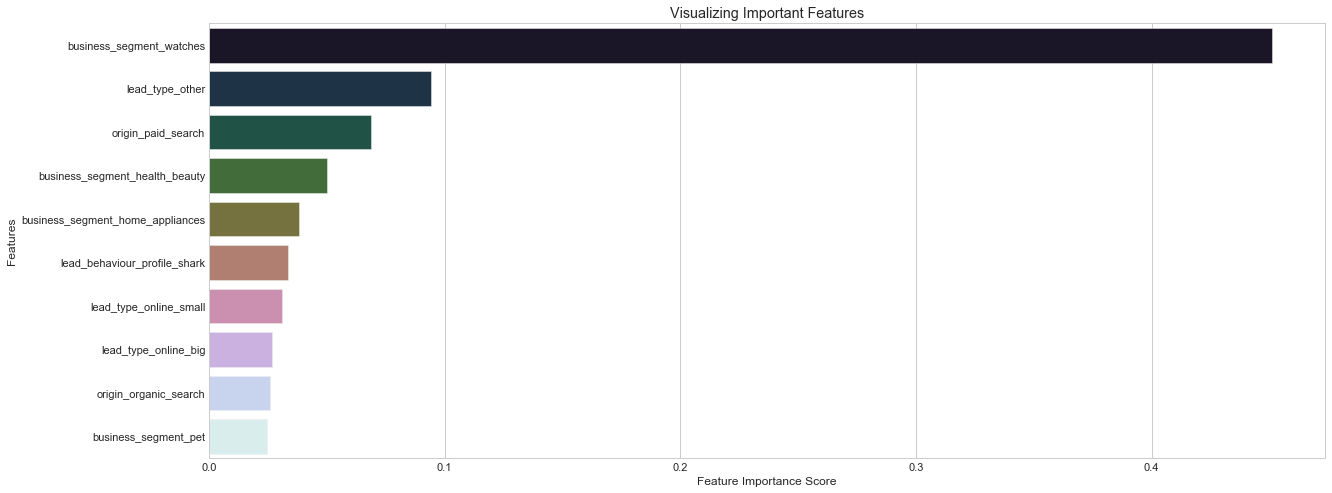

In [326]:
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## <font color='blue'>Conclusion</font>
<a id=part3></a>
From the prediction analysis we got the following results:

| Metric      | Baseline    | Linear Regression    | Random Forrest | Support Vector Machine |
|-------------|-------------|----------------------|----------------|------------------------|
| MAE (train) |   23.07 BRL |            17.87 BRL |     8.11 BRL   |   16.59 BRL            |
| MSE (train) | 4946.70 BRL |          1096.26 BRL |   764.20 BRL   | 5089.18 BRL            |
| MAE (test)  |   14.95 BRL | 1638057968176.62 BRL |    32.12 BRL   |    9.83 BRL            |
| MSE (test)  |  312.82 BRL |     6.797526e+25 BRL | 10791.97 BRL   |  308.37 BRL            |

The above table makes it clear that Support Vector Machine was the only model performing better than the baseline. Though, it also manage to perform better on unseen data than seen data. Telling us the prediction on new samples are not reliable. Therefor the predictive analysis tells us:

- That none of the models performs significantly better than the mean prediction. Thus, none of models will add any business value to Olist and should be implemented in the near future.
- However, the predictive analysis has delivered a proof of concept. We see some signals telling us that we are able to learn from past experience. But we need more data and because of the limitied amount of historical data it could be an idea to re-think the information the Sales Development Representatives gather.
- The proof of concept consider the ability to prioritize qualified marketing leads based on the predicted average weekly revenue. And organize Sales Representatives in order to increase the number of sellers generating a high average weekly revenue.
- It will also be valuable to consider this as a classification problem instead of a regression problem. Thus, sellers must be divided into k classes based on their average weekly revenue. Then the problem will be simplified and maybe this will produce a better prediction rule. 